In [1]:
import os
import numpy as np
import pandas as pd
import json
from parallel_robust_forest import load_attack_rules
from sklearn.model_selection import train_test_split
from joblib import Parallel,delayed
import sys
import collections, functools, operator 
from collections import defaultdict
import dill
import lightgbm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib.pylab as pl
%matplotlib inline

In [2]:
def load_data(path):
    
    return pd.read_csv(os.path.join(path)) 
                       

In [3]:
def load_model(model_file):
    model = None
    try:
        model = lightgbm.Booster(model_file=model_file)
    except:
        print("LightGBM loading exception")
        try:
            with open(model_file, 'rb') as mf:
                model = dill.load(mf)
                print(model)
                model.n_jobs = 16
        except Exception as e:
            print(e)
            print("Dill loading exception")
            pass
    
    return model

In [4]:
def Rf_feature_importance(node, out=sys.stdout,d=None, tabs=''):
    if d is None:
        d = defaultdict(float)

    if node.is_leaf(): 
        pass

    else: 
        
        Rf_feature_importance(node.left,out,d,tabs +"\t")
        Rf_feature_importance(node.right,out,d,tabs +"\t")
 
        d[node.best_split_feature_id] += node.gain_value
        
    return d

In [5]:
def gbdt_feature_imortance(model, colnames):
    fx_uses = model.feature_importance(importance_type='split')
    fx_gain = model.feature_importance(importance_type='gain')
    df = pd.DataFrame(columns=['Name','Gain'])
    for i,f in enumerate(np.argsort(fx_gain)[::-1]):
        ("{:2d} {:20s} {:.3f} {:4d}".format(i, colnames[f], fx_gain[f], fx_uses[f]))
        df=df.append({'Name':colnames[f],'Gain':fx_gain[f]}, ignore_index=True)
    return df

# wine

In [6]:
DATASET_NAME="wine"
DATASET_DIR="../data/{}".format(DATASET_NAME)
OUTPUT_FILENAME="../out/results/{}".format(DATASET_NAME)
TRAINING_FILENAME =DATASET_DIR + "/" + "train.csv.bz2"

train = load_data(TRAINING_FILENAME)

# Adversarial Boosting

In [7]:
def print_fx_imp(model, colnames):
    fx_uses = model.feature_importance(importance_type='split')
    fx_gain = model.feature_importance(importance_type='gain')
    df = pd.DataFrame(columns=['Name','Gain'])
    for i,f in enumerate(np.argsort(fx_gain)[::-1]):
        ("{:2d} {:20s} {:.3f} {:4d}".format(i, colnames[f], fx_gain[f], fx_uses[f]))
        df=df.append({'Name':colnames[f],'Gain':fx_gain[f]}, ignore_index=True)
    return df
#print("-- adversarial boosting--")    
gbdt = lightgbm.Booster(model_file="../out/models/wine/adv-boosting_wine_B40_T100_S0050_L256_R100.model")
advb =print_fx_imp(gbdt, train.columns)
advb.loc[:,'N-Gain']=advb['Gain'].div(advb['Gain'].sum())


# Random Forest

In [8]:
def print_fx_imp(model, colnames):
    fx_uses = model.feature_importance(importance_type='split')
    fx_gain = model.feature_importance(importance_type='gain')
    df = pd.DataFrame(columns=['Random-Name','Gain'])
    for i,f in enumerate(np.argsort(fx_gain)[::-1]):
        ("{:2d} {:20s} {:.3f} {:4d}".format(i, colnames[f], fx_gain[f], fx_uses[f]))
        df=df.append({'Random-Name':colnames[f],'Gain':fx_gain[f]}, ignore_index=True)
    return df
#print("-- adversarial boosting--")    
gbdt = lightgbm.Booster(model_file="../out/models/wine/adv-boosting_wine_B40_T100_S0050_L256_R100.model")
random_forest =print_fx_imp(gbdt, train.columns)
random_forest.loc[:,'N-Gain']=random_forest['Gain'].div(random_forest['Gain'].sum())


# TREANT

In [9]:
with open("../out/models/wine/par-robust_wine_L-sse_B40_T100_D8_I20.model", 'rb') as f:
    model = dill.load(f)

l=[]
for i in range(model.n_estimators):
    tree_dic =Rf_feature_importance(model.estimators_[i].root)
    l.append(tree_dic)

# combining list of dictionaries by suming the values of same key 
result = dict(functools.reduce(operator.add, 
         map(collections.Counter, l))) 

dft = pd.DataFrame.from_dict(result, orient='index',
                       columns=['Gain'])

dft.loc[:,'TREANTName'] = train.columns[list(result.keys())]
dft.loc[:,'N-Gain']=dft['Gain'].div(dft['Gain'].sum())
dft.loc[11] = [0.000000, 'is_white', 0.000000]
treant=dft.sort_values(by=['Gain'],ascending=False)
sub_treant =treant
#print("-- Treant --") 

sub_treant

,Gain,TREANTName,N-Gain
10,5764.501108,alcohol,0.206438
2,3641.815461,citric_acid,0.130421
7,3262.873322,density,0.116850
5,3059.179147,free_sulfur_dioxide,0.109555
4,2911.166573,chlorides,0.104255
6,2319.532530,total_sulfur_dioxide,0.083067
9,2181.307549,sulphites,0.078117
3,1600.750940,residual_sugar,0.057326
8,1461.421869,pH,0.052336
0,1405.328651,fixed_acidity,0.050328


# Robust TREES

In [10]:
with open("../out/models/wine/icml2019_wine_L-sse_B40_T100_D8_I20.model", 'rb') as f:
    model = dill.load(f)
l=[]
for i in range(model.n_estimators):
    tree_dic =Rf_feature_importance(model.estimators_[i].root)
    l.append(tree_dic)

# combining list of dictionaries by suming the values of same key 
result = dict(functools.reduce(operator.add, 
         map(collections.Counter, l))) 

dft = pd.DataFrame.from_dict(result, orient='index',
                       columns=['Gain'])
dft.loc[:,'RobustName'] = train.columns[list(result.keys())]
dft.loc[:,'N-Gain']=dft['Gain'].div(dft['Gain'].sum())
dft.loc[11] = [0.000000, 'is_white', 0.000000]
robust_tree = dft.sort_values(by=['Gain'],ascending=False)
robust_tree= dft.sort_values(by=['Gain'],ascending=False)
#print("-- Robust Tree --") 


In [11]:
# collecting all the top 10 features along with gain and normalized gain value 
df = pd.DataFrame(columns=['AB-Name','TREANT-Name','Robust-Name','Random-Name','Adv Boosting',
                           'RF-TREANT','Robust Trees','Random Forest'])
df['AB-Name'] =advb['Name']
df['TREANT-Name']= treant['TREANTName'].tolist() 
df['Robust-Name']= robust_tree['RobustName'].tolist()
df['Random-Name']=random_forest['Random-Name']
df['Adv Boosting'] = advb['N-Gain']
df['RF-TREANT']=treant['N-Gain'].tolist() 
df['Robust Trees']=robust_tree['N-Gain'].tolist()
df['Random Forest']=random_forest['N-Gain']

# creating a combined new data frame ordered by the feature name apperance in TREANT
wine = pd.DataFrame(columns=['Name','Adv Boosting','RF-TREANT','Robust Trees','Random Forest'])
wine['Name']=np.unique(df[['AB-Name', 'TREANT-Name','Robust-Name','Random-Name']].values)
cnames = wine['Name'].tolist()

# list of list values of the normalized gain for the three algorithms
rf=[]
tr =[]
ab =[]
random=[]
for i in range(len(cnames)):
    rf.append(robust_tree[robust_tree['RobustName']==cnames[i]]['N-Gain'].tolist())
    tr.append(treant[treant['TREANTName']==cnames[i]]['N-Gain'].tolist())
    ab.append(advb[advb['Name']==cnames[i]]['N-Gain'].tolist())
    random.append(random_forest[random_forest['Random-Name']==cnames[i]]['N-Gain'].tolist())
    
# adding the flattend lists to the dataframe, if a value doesn't exist replaced by zero    
wine['Adv Boosting']= [val for sublist in ab for val in (sublist or [0])]
wine['RF-TREANT']= [val for sublist in tr for val in (sublist or [0])]    
wine['Robust Trees']= [val for sublist in rf for val in (sublist or [0])] 
wine['Random Forest']= [val for sublist in random for val in (sublist or [0])]

wine=wine.sort_values(by=['RF-TREANT'],ascending=False)        
       

# Plotting Wine

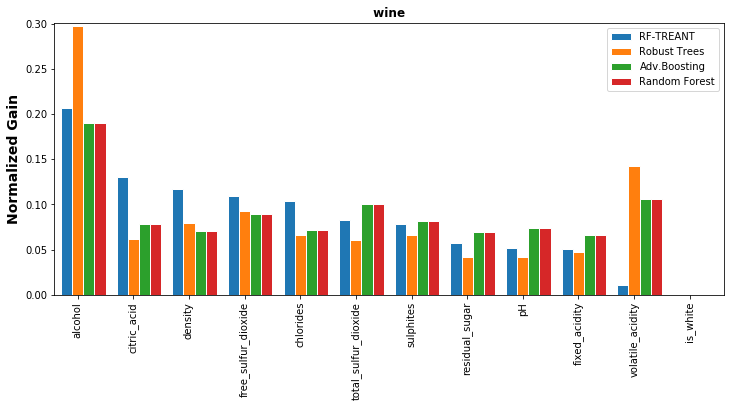

In [23]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
# set width of bar
barWidth = 0.20


# set height of bar
bars1 = wine['RF-TREANT'].tolist()
bars2 = wine['Robust Trees'].tolist()
bars3 = wine['Adv Boosting'].tolist()
bars4 = wine['Random Forest'].tolist()
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth  for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Make the plot
plt.bar(r1, bars1,  width=barWidth, edgecolor='white', label='RF-TREANT')
plt.bar(r2, bars2,  width=barWidth, edgecolor='white', label='Robust Trees')
plt.bar(r3, bars3,  width=barWidth, edgecolor='white', label='Adv.Boosting')
plt.bar(r4,bars4,  width=barWidth , edgecolor='white', label='Random Forest')

# Add xticks on the middle of the group bars
#plt.xlabel('Feature Names', fontweight='bold',fontsize =16)
plt.ylabel('Normalized Gain',fontweight='bold',fontsize=14)

plt.xticks([r +  barWidth for r in range(len(wine['Name']))], wine['Name'].tolist()
                                                        ,rotation=90)
# Create legend & Show graphic
plt.title(' wine ',fontweight='bold',fontsize =12)
plt.margins(0.01)
plt.legend()
plt.show()

# Malware

In [ ]:
DATASET_NAME="malware_all"
DATASET_DIR="../data/{}".format(DATASET_NAME)
ATK_DIR=DATASET_DIR + "/attacks"
MODELS_DIR="../out/models/{}".format(DATASET_NAME)
TRAINING_FILENAME=DATASET_DIR + "/" + "train.csv.bz2"
train = load_data(TRAINING_FILENAME)

In [ ]:
def print_fx_imp(model, colnames):
    fx_uses = model.feature_importance(importance_type='split')
    fx_gain = model.feature_importance(importance_type='gain')
    df = pd.DataFrame(columns=['Name','Gain'])
    for i,f in enumerate(np.argsort(fx_gain)[::-1]):
        ("{:2d} {:20s} {:.3f} {:4d}".format(i, colnames[f], fx_gain[f], fx_uses[f]))
        df=df.append({'Name':colnames[f],'Gain':fx_gain[f]}, ignore_index=True)
    return df
#print("-- adversarial boosting--")    
gbdt = lightgbm.Booster(model_file="../out/models/malware_all/adv-boosting_malware_all_B40_T100_S0050_L256_R78.model")
advb =print_fx_imp(gbdt, train.columns)
advb.loc[:,'N-Gain']=advb['Gain'].div(advb['Gain'].sum())


# Random Forest

In [ ]:
def print_fx_imp(model, colnames):
    fx_uses = model.feature_importance(importance_type='split')
    fx_gain = model.feature_importance(importance_type='gain')
    df = pd.DataFrame(columns=['Random-Name','Gain'])
    for i,f in enumerate(np.argsort(fx_gain)[::-1]):
        ("{:2d} {:20s} {:.3f} {:4d}".format(i, colnames[f], fx_gain[f], fx_uses[f]))
        df=df.append({'Random-Name':colnames[f],'Gain':fx_gain[f]}, ignore_index=True)
    return df
#print("-- adversarial boosting--")    
gbdt = lightgbm.Booster(model_file="../out/models/malware_all/rf-gbdt_malware_all_T100_S0050_L256_R97.model")
random_forest =print_fx_imp(gbdt, train.columns)
random_forest.loc[:,'N-Gain']=random_forest['Gain'].div(random_forest['Gain'].sum())


# TREANT

In [ ]:
with open("../out/models/malware_all/par-robust_malware_L-sse_B40_T100_D8_I20.model", 'rb') as f:
    model = dill.load(f)

l=[]
for i in range(model.n_estimators):
    tree_dic =Rf_feature_importance(model.estimators_[i].root)
    l.append(tree_dic)

# combining list of dictionaries by suming the values of same key 
result = dict(functools.reduce(operator.add, 
         map(collections.Counter, l))) 

dft = pd.DataFrame.from_dict(result, orient='index',
                       columns=['Gain'])

dft.loc[:,'TREANTName'] = train.columns[list(result.keys())]
dft.loc[:,'N-Gain']=dft['Gain'].div(dft['Gain'].sum())
treant=dft.sort_values(by=['Gain'],ascending=False)
sub_treant =treant
#print("-- Treant --") 
#sub_treant[:10]

# Robust TREES

In [ ]:
with open("../out/models/malware_all/icml2019_malware_L-sse_B40_T100_D8_I20.model", 'rb') as f:
    model = dill.load(f)
l=[]
for i in range(model.n_estimators):
    tree_dic =Rf_feature_importance(model.estimators_[i].root)
    l.append(tree_dic)

# combining list of dictionaries by suming the values of same key 
result = dict(functools.reduce(operator.add, 
         map(collections.Counter, l))) 

dft = pd.DataFrame.from_dict(result, orient='index',
                       columns=['Gain'])
dft.loc[:,'RobustName'] = train.columns[list(result.keys())]
dft.loc[:,'N-Gain']=dft['Gain'].div(dft['Gain'].sum())
robust_tree = dft.sort_values(by=['Gain'],ascending=False)
robust_tree= dft.sort_values(by=['Gain'],ascending=False)
#print("-- Robust Tree --") 
#robust_tree[:10]

In [ ]:
# collecting all the top 10 features along with gain and normalized gain value 
df = pd.DataFrame(columns=['AB-Name','TREANT-Name','Robust-Name','Random-Name','Adv Boosting',
                           'RF-TREANT','Robust Trees','Random Forest'])
df['AB-Name'] =advb['Name'][:10]
df['TREANT-Name']= treant['TREANTName'][:10].tolist() 
df['Robust-Name']= robust_tree['RobustName'][:10].tolist()
df['Random-Name']=random_forest['Random-Name'][:10]
df['Adv Boosting'] = advb['N-Gain'][:10]
df['RF-TREANT']=treant['N-Gain'][:10].tolist() 
df['Robust Trees']=robust_tree['N-Gain'][:10].tolist()
df['Random Forest']=random_forest['N-Gain'][:10]

# creating a combined new data frame ordered by the feature name apperance in TREANT
malware = pd.DataFrame(columns=['Name','Adv Boosting','RF-TREANT','Robust Trees','Random Forest'])
malware['Name']=np.unique(df[['AB-Name', 'TREANT-Name','Robust-Name','Random-Name']].values)
cnames = malware['Name'].tolist()

# list of list values of the normalized gain for the three algorithms
rf=[]
tr =[]
ab =[]
random=[]
for i in range(len(cnames)):
    rf.append(robust_tree[robust_tree['RobustName']==cnames[i]]['N-Gain'].tolist())
    tr.append(treant[treant['TREANTName']==cnames[i]]['N-Gain'].tolist())
    ab.append(advb[advb['Name']==cnames[i]]['N-Gain'].tolist())
    random.append(random_forest[random_forest['Random-Name']==cnames[i]]['N-Gain'].tolist())
    
# adding the flattend lists to the dataframe, if a value doesn't exist replaced by zero    
malware['Adv Boosting']= [val for sublist in ab for val in (sublist or [0])]
malware['RF-TREANT']= [val for sublist in tr for val in (sublist or [0])]    
malware['Robust Trees']= [val for sublist in rf for val in (sublist or [0])] 
malware['Random Forest']= [val for sublist in random for val in (sublist or [0])]

malware=malware.sort_values(by=['RF-TREANT'],ascending=False)        
     

# Plotting malware feature importance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))

# set width of bar
barWidth = 0.20
width = 0.2

# set height of bar
bars1 = malware['RF-TREANT'].tolist()
bars2 = malware['Robust Trees'].tolist()
bars3 = malware['Adv Boosting'].tolist()
bars4 = malware['Random Forest'].tolist()
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth  for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Make the plot
plt.bar(r1, bars1,  width=barWidth, edgecolor='white', label='RF-TREANT')
plt.bar(r2, bars2,  width=barWidth, edgecolor='white', label='Robust Trees')
plt.bar(r3, bars3,  width=barWidth, edgecolor='white', label='Adv.Boosting')
plt.bar(r4,bars4,  width=barWidth , edgecolor='white', label='Random Forest')

# Add xticks on the middle of the group bars
plt.xlabel('Feature Names', fontweight='bold',fontsize =16)
plt.ylabel('Normalized Gain',fontweight='bold',fontsize=14)
plt.ylabel('Normalized Gain Value', fontweight='bold',fontsize =12)
plt.xticks([r +  barWidth for r in range(len(malware['Name']))], malware['Name'].tolist()
                                                        ,rotation=90)

# Create legend & Show graphic
plt.title(' malware ',fontweight='bold',fontsize =12)
plt.margins(0.01)
plt.legend()
plt.show()

In [ ]:

frames = {}

groups = ['malware', 'wine']
for grp in groups:
    df1 = malware
    df2 = new
    
    if grp =='malware':
        frames[grp]=df1
    if grp =='wine':
        frames[grp]=df2
    else:
        pass

    

In [ ]:
index1= wine['Name'].tolist()
index2 = malware['Name'].tolist()
df1 = pd.DataFrame({'RF-TREANT': wine['RF-TREANT'].tolist(),
                    'Robust Trees':wine['Robust Trees'].tolist(),
                    'Adv Boosting':wine['Adv Boosting'].tolist(),
                     'Random Forest':wine['Random Forest'].tolist()}, index=index1)

df2 = pd.DataFrame({'RF-TREANT': malware['RF-TREANT'].tolist(),
                    'Robust Trees':malware['Robust Trees'].tolist(),
                    'Adv Boosting':malware['Adv Boosting'].tolist(),
                    'Random Forest':malware['Random Forest'].tolist()}, index=index2)



In [ ]:
fig,axes = pl.subplots(nrows=1, ncols=2,figsize=(15,5))

labels = axes[0].get_legend_handles_labels()
fig.legend(labels=['RF-TREANT','Robust Trees','Adv Boosting','Random Forest'], loc='upper center')
#fig.legend =['RF-TREANT','Robust Trees','Adv Boosting','Random Forest']
df1.plot.bar(ax=axes[0],rot=90)
df2.plot.bar(ax=axes[1],rot=90)

axes[0].set_title("Wine")
axes[1].set_title("Malware")
axes[0].set_xlabel("Wine Dataset features",fontsize=20)
axes[1].set_xlabel("Malware Dataset features",fontsize=20)
axes[0].get_legend()
plt.gcf().subplots_adjust(bottom=0.20)
#pl.savefig('feature_importance.png')